<a href="https://colab.research.google.com/github/casual-lab/colab-notebooks/blob/main/medical_instance_segmentation_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%shell
echo \{\"username\":\"bob0000young\",\"key\":\"a2ebbf25da04c47c386a59f8afaad20c\"\} > ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

python -m pip install --upgrade pip
pip install kaggle
# kaggle competitions list
kaggle datasets download -d andrewmvd/cancer-inst-segmentation-and-classification -w --unzip

 99% 737M/741M [00:30<00:00, 25.7MB/s]
100% 741M/741M [00:30<00:00, 25.3MB/s]


In [ ]:
import numpy as np
from PIL import Image
import os
import torch
import torch.utils.data


In [ ]:
np_types = np.load("./Images/types.npy")
idx = np.where(np_types=='Lung')

tissue_names = "Breast, Colon, Bile-duct, Esophagus, Uterus, Lung, Cervix, Head&Neck, Skin, Adrenal Gland, Kidney, Stomach, Prostate, Testis, Liver, Thyroid, Pancreas, Ovary, Bladder".split(", ")
tissue_dict = [(name, np.where(np_types==name)[0].shape[0]) for name in tissue_names]
tissue_dict

[('Breast', 827),
 ('Colon', 478),
 ('Bile-duct', 159),
 ('Esophagus', 155),
 ('Uterus', 17),
 ('Lung', 80),
 ('Cervix', 155),
 ('Head&Neck', 0),
 ('Skin', 59),
 ('Adrenal Gland', 0),
 ('Kidney', 37),
 ('Stomach', 50),
 ('Prostate', 77),
 ('Testis', 60),
 ('Liver', 65),
 ('Thyroid', 80),
 ('Pancreas', 0),
 ('Ovary', 0),
 ('Bladder', 21)]

In [ ]:
np_images = np.load("./Images/images.npy")[idx]
np_images.shape

(80, 256, 256, 3)

In [ ]:
np_masks = np.load("./Masks/masks.npy")[idx]
np_masks.shape

(80, 256, 256, 6)

In [ ]:
concer_ids = []
for i in range(len(np_masks)):
  if len(np.unique(np_masks[i, :, :, 0])) == 1:
    continue
  concer_ids.append(i)
np_masks = np.uint8(np_masks[concer_ids][:, :, :, 0])
np_images = np.uint8(np_images[concer_ids])
np_images.shape, np_masks.shape

((72, 256, 256, 3), (72, 256, 256))

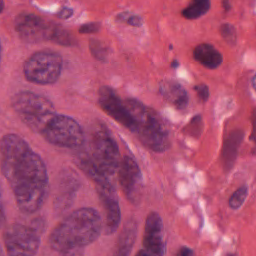

In [ ]:
eg_id = 0
img = Image.fromarray(np.uint8(np_images[eg_id]))
img

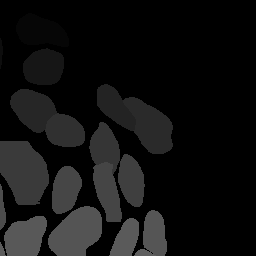

In [ ]:
mask = Image.fromarray(np.uint8(np_masks[eg_id]))
mask

In [ ]:
class KaggleDataset(torch.utils.data.Dataset):
  def __init__(self, np_imgs, np_msks, transforms=None):
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    self.imgs = np_imgs
    self.masks = np_msks

  def __getitem__(self, idx):
    # load images ad masks
    img = Image.fromarray(self.imgs[idx]).convert("RGB")
    # note that we haven't converted the mask to RGB,
    # because each color corresponds to a different instance
    # with 0 being background
    mask = Image.fromarray(self.masks[idx])

    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set
    # of binary masks
    masks = (mask == obj_ids[:, None, None])

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      if xmin == xmax or ymin == ymax: continue
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
dataset = KaggleDataset(np_images, np_masks)
dataset[0]

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FB5148E3F50>,
 {'area': tensor([1716.,   60., 1440., 1748., 1978., 2744., 1287., 1530., 3024., 1352.,
          1652., 1363.,  225., 2597., 1035., 1638., 1073.,   65.,  126.]),
  'boxes': tensor([[ 16.,  13.,  68.,  46.],
          [  0.,  38.,   2.,  68.],
          [ 23.,  48.,  63.,  84.],
          [ 97.,  84., 135., 130.],
          [ 10.,  89.,  56., 132.],
          [123.,  97., 172., 153.],
          [ 45., 113.,  84., 146.],
          [ 89., 122., 119., 173.],
          [  0., 141.,  48., 204.],
          [118., 154., 144., 206.],
          [ 93., 162., 121., 221.],
          [ 52., 166.,  81., 213.],
          [  0., 184.,   5., 229.],
          [ 48., 206., 101., 255.],
          [143., 210., 166., 255.],
          [  4., 216.,  46., 255.],
          [109., 218., 138., 255.],
          [  0., 242.,   5., 255.],
          [134., 249., 155., 255.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_model_coco_resnet50(num_classes):
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 118104, done.
remote: Counting objects: 100% (10810/10810), done.
remote: Compressing objects: 100% (953/953), done.
remote: Total 118104 (delta 9934), reused 10577 (delta 9803), pack-reused 107294
Receiving objects: 100% (118104/118104), 231.68 MiB | 12.16 MiB/s, done.
Resolving deltas: 100% (102578/102578), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

一切就绪，下面测试foward：

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = KaggleDataset(np_images, np_masks, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)        # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)            # Returns predictions

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# use our dataset and defined transformations
dataset = KaggleDataset(np_images, np_masks, get_transform(train=True))
dataset_test = KaggleDataset(np_images, np_masks, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_coco_resnet50(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # update the learning rate 
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/11]  eta: 0:00:23  lr: 0.000505  loss: 4.5820 (4.5820)  loss_classifier: 0.7192 (0.7192)  loss_box_reg: 0.6393 (0.6393)  loss_objectness: 3.0231 (3.0231)  loss_rpn_box_reg: 0.2004 (0.2004)  time: 2.1294  data: 0.5904  max mem: 1623
Epoch: [0]  [10/11]  eta: 0:00:01  lr: 0.005000  loss: 1.8491 (2.7091)  loss_classifier: 0.5434 (0.5275)  loss_box_reg: 0.6393 (0.5777)  loss_objectness: 0.4774 (1.4092)  loss_rpn_box_reg: 0.1642 (0.1947)  time: 1.1894  data: 0.0632  max mem: 1891
Epoch: [0] Total time: 0:00:13 (1.2118 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:35  model_time: 0.2703 (0.2703)  evaluator_time: 0.0808 (0.0808)  time: 0.7033  data: 0.3512  max mem: 1891
Test:  [49/50]  eta: 0:00:00  model_time: 0.2642 (0.2636)  evaluator_time: 0.0568 (0.0557)  time: 0.3313  data: 0.0052  max mem: 1891
Test: Total time: 0:00:16 (0.3374 s / it)
Averaged stats: model_time: 0.2642 (0.2636)  evaluator_time: 0.0568 (0.0557)
Accumulating evaluation results...
DO

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

[{key:prediction[key].shape} for key in prediction.keys]

TypeError: ignored

In [ ]:
def compute_pred_box_area(preds):
  for p in preds:
    areas = []
    for xa, ya, xb, yb in p['boxes'].tolist():
      area = (xb-xa)*(yb-ya)
      areas.append(area)   
    p['areas'] = np.array(areas)

  return preds

compute_pred_box_area(prediction)
prediction[0]['areas'].shape, prediction[0]['boxes'].shape

((100,), torch.Size([100, 4]))

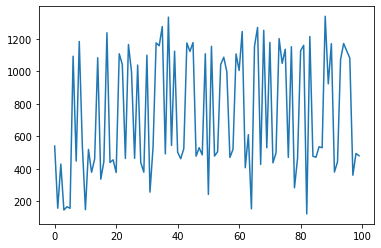

In [ ]:
import matplotlib.pyplot as plt

plt.plot(prediction[0]['areas'])

In [ ]:
prediction

[{'areas': array([ 539.91030707,  157.97551754,  429.03393946,  146.85022629,
          166.87469832,  157.4536903 , 1092.30474677,  447.69666298,
         1182.63908676,  541.98093579,  148.89573144,  518.94291367,
          378.8521041 ,  459.06661829, 1082.62591268,  336.60323628,
          444.11114179, 1236.00637025,  439.12915563,  455.38000263,
          377.30248714, 1107.05361664, 1041.85990729,  463.88855073,
         1163.85377705,  994.75589155,  464.60449105, 1037.6253158 ,
          439.3672639 ,  379.48956901, 1098.46543599,  256.69949338,
          532.84601984, 1173.86409162, 1156.566434  , 1274.44864748,
          491.89420514, 1332.16719066,  544.10638367, 1123.20779142,
          501.90879267,  462.27928674,  523.37974923, 1173.42123338,
         1121.76064708, 1175.79834981,  477.59000466,  530.0320804 ,
          485.58286585, 1107.32242308,  242.84293804, 1153.11380968,
          478.54150061,  505.56262552, 1040.61011226, 1085.86276103,
          996.58242571,  

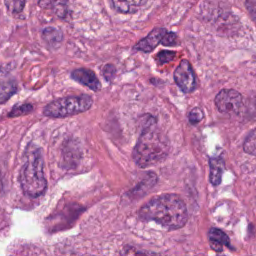

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

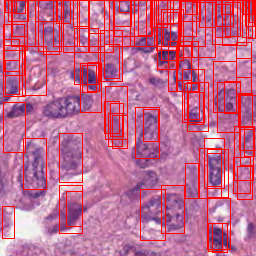

In [ ]:
from PIL import Image, ImageDraw, ImageFont
origin = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(origin)
for box in prediction[0]['boxes']:
  draw.rectangle(xy=tuple(box), fill=None, outline="red", width=1)
origin

# 接下来测试更换预训练模型之后

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
def get_model_medicalnet(num_classes):
  # 尝试更换为 MedicalNet backbone，

  backbone = torchvision.models.mobilenet_v2(pretrained=True).features
  backbone.out_channels = 1280

  anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0], output_size=7, sampling_ratio=2)

  # put the pieces together inside a FasterRCNN model
  model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

In [ ]:
%%shell
git clone https://github.com/Tencent/MedicalNet

cd MedicalNet
cp models/resnet.py ../

pip install torchsummary

Cloning into 'MedicalNet'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 114 (delta 48), reused 43 (delta 43), pack-reused 50
Receiving objects: 100% (114/114), 47.63 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
import torch 
from torchsummary import summary

pretrained = torch.load("/content/drive/MyDrive/medicalnet-pretrain/resnet_50_23dataset.pth")

pretrained['state_dict'] = {k.replace('module.',''):v for k,v in pretrained['state_dict'].items()}
pretrained['state_dict'].keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.wei

In [ ]:
import resnet
from torch import nn

model = resnet.resnet50(sample_input_W=256,
            sample_input_H=256,
            sample_input_D=1,
            shortcut_type='B',
            no_cuda=(not torch.cuda.is_available()),
            num_seg_classes=2)


model = model.cuda() 
# model = nn.DataParallel(model, device_ids=None)
net_dict = model.state_dict()

net_dict = model.state_dict()
net_dict.keys()

/content/resnet.py:173: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [ ]:
len(backbone.state_dict().keys()), len(model.state_dict().keys()), len(pretrained['state_dict'].keys())

(318, 332, 318)

In [ ]:
[pname for pname in model.state_dict().keys() if pname not in pretrained['state_dict'].keys()]

['conv_seg.0.weight',
 'conv_seg.0.bias',
 'conv_seg.1.weight',
 'conv_seg.1.bias',
 'conv_seg.1.running_mean',
 'conv_seg.1.running_var',
 'conv_seg.1.num_batches_tracked',
 'conv_seg.3.weight',
 'conv_seg.4.weight',
 'conv_seg.4.bias',
 'conv_seg.4.running_mean',
 'conv_seg.4.running_var',
 'conv_seg.4.num_batches_tracked',
 'conv_seg.6.weight']

In [ ]:
np.unique([(model.state_dict()[pname].shape==pretrained['state_dict'][pname].shape) for pname in pretrained['state_dict'].keys()])

array([ True])

In [ ]:
pretrain_dict = {k: v for k, v in pretrained['state_dict'].items() if k in net_dict.keys()}
         
net_dict.update(pretrain_dict)
model.load_state_dict(net_dict)

new_parameters = [] 
new_layer_names = ['conv_seg']
for pname, p in model.named_parameters():
  for layer_name in new_layer_names:
    if pname.find(layer_name) >= 0:
      new_parameters.append(p)
      break

new_parameters_id = list(map(id, new_parameters))
base_parameters = list(filter(lambda p: id(p) not in new_parameters_id, model.parameters()))

In [ ]:
summary(model, (1, 3, 256, 256))

In [ ]:
backbone = nn.Sequential(
    model.conv1(x), model.bn1(x), model.relu(x), model.maxpool(x), 
    model.layer1(x), model.layer2(x), model.layer3(x), model.layer4(x)
)
summary(backbone, (1, 3, 256, 256))

In [ ]:
import torch 
from torch import nn
import resnet

def get_pretrained_backbone():
  pretrained = torch.load("/content/drive/MyDrive/medicalnet-pretrain/resnet_50_23dataset.pth")
  pretrained['state_dict'] = {k.replace('module.',''):v for k,v in pretrained['state_dict'].items()}

  # 论文源码专门实现的 ResNet
  model = resnet.resnet50(sample_input_W=256,
              sample_input_H=256,
              sample_input_D=1,
              shortcut_type='B',
              no_cuda=(not torch.cuda.is_available()),
              num_seg_classes=2)
  model = model.cuda() 
  # model = nn.DataParallel(model, device_ids=None)
  net_dict = model.state_dict()

  pretrain_dict = {k: v for k, v in pretrained['state_dict'].items() if k in net_dict.keys()}
         
  net_dict.update(pretrain_dict)
  model.load_state_dict(net_dict)

  new_parameters = [] 
  new_layer_names = ['conv_seg']
  for pname, p in model.named_parameters():
    for layer_name in new_layer_names:
      if pname.find(layer_name) >= 0:
        new_parameters.append(p)
        break

  new_parameters_id = list(map(id, new_parameters))
  base_parameters = list(filter(lambda p: id(p) not in new_parameters_id, model.parameters()))

  backbone = nn.Sequential(
      model.conv1(x), model.bn1(x), model.relu(x), model.maxpool(x), 
      model.layer1(x), model.layer2(x), model.layer3(x), model.layer4(x)
  )

  return model, backbone, {"new_param": new_parameters, "base_param": base_parameters}